In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import dlib

### 1. 이미지에서 얼굴과 랜드마크 검출

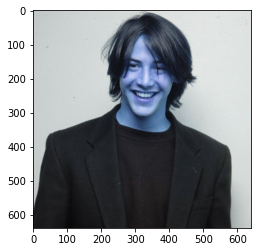

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/fundamental/0930/images/keanu.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

* opencv는 예외적으로 BGR(파랑, 녹색, 빨강)을 사용 (보통은 RGB)
* 원본 사진에서 붉은색은 푸른색으로, 푸른색은 붉은색으로 바뀌어 출력되었음 
* 그래서, opencv에서 다룬 이미지를 다른 이미지 라이브러리를 활용하여 출력하려면 색깔 보정 처리해야함

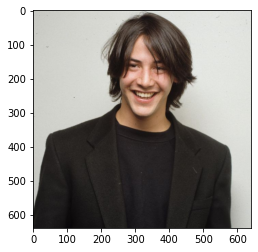

In [3]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [4]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

In [5]:
## detector 이용해서 얼굴의 boundary box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

얼굴 좌표: rectangles[[(242, 118) (428, 304)]]


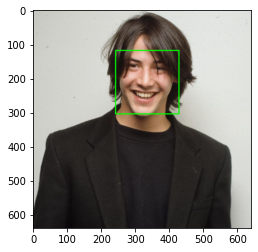

In [6]:
print("얼굴 좌표:",  dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects: #찾은 얼굴 영역의 사각형을 그림
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#### 랜드마크 모델

In [7]:
model_path = os.getenv('HOME')+'/aiffel/fundamental/0930/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환합니다.

In [8]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


* points 는 dlib.full_object_detection 의 객체이기 때문에 parts() 함수로 개별 위치에 접근. 
* 조금 더 직관적인 (x, y) 형태로 접근할 수 있도록 변환. 
* 따라서 list_points 는 tuple (x, y) 68개로 이루어진 리스트임. 
* 이미지에서 찾아진 얼굴 개수마다 반복하면 list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장

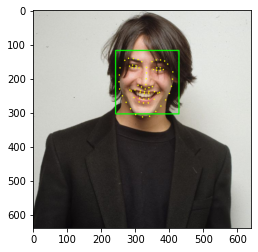

In [9]:
#랜드마크를 영상에 출력

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 2. 스티커 적용하기

먼저 좌표 먼저 확인을 한다: (x,y) 코의 중심점, (w,h) 스티커 크기 

In [10]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print ("코 중심:", landmark[30]) # nose center index : 30
    
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    
    w = dlib_rect.width() #얼굴 폭
    h = dlib_rect.width() # 얼굴 높이 
    
    print ("코 좌표:", '(x,y) : (%d,%d)'%(x,y))
    print ("얼굴 크기:",'(w,h) : (%d,%d)'%(w,h))

코 중심: (331, 218)
코 좌표: (x,y) : (331,125)
얼굴 크기: (w,h) : (187,187)


그에 따라 스티커 크기를 조정한다.

In [11]:
sticker_path = os.getenv('HOME')+'/aiffel/fundamental/0930/images/catwhisker.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 크기를 얼굴 랜드마크 크기로 조정

print (img_sticker.shape)

(187, 187, 3)


In [12]:
refined_x = x - w // 2  # left
refined_y = y       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (238,125)


그 다음 얼굴에서 스티커가 붙여질 범위(sticker_area) 출력 및 스티커 적용할 수 있다. 

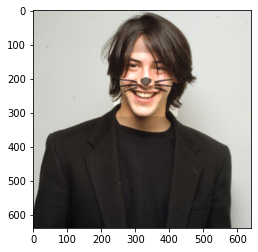

In [13]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.7, 0)
# cv2.addWeighted() 참고

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

* 얼굴 범위가 작은데 RGB변환 적용했을 때 얼굴 인식한 부분만 색깔이 나머지랑 다르게 나온다. 코드 실행될 때마다 더 심해진다. 어떻게 고칠 수 있는지 모르겠다

### 3. 가능한 문제점 적용해보기 

* 각도
* 거리 
* 실행 속도
* 정확도

다음 참고하였음:https://github.com/hyyoo3526/AIFFEL_EXPLORATION/blob/main/EXPLORATION_03/EXPLORATION_IC1_03_camera_sticker_app.ipynb

#### 3.1 각도

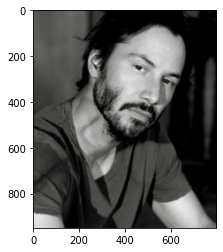

In [14]:
my_image_path = os.getenv('HOME')+'/aiffel/fundamental/0930/images/keanu_tilted.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

rectangles[[(290, 162) (675, 547)]]
68


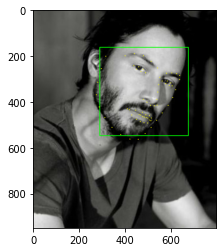

In [15]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
dlib_rects = detector_hog(img_rgb, 1)   # detector_hog(image, 이미지 피라미드 수)
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))


for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

(538, 389)
(x,y) : (538,196)
(w,h) : (386,386)
(386, 386, 3)
(x,y) : (345,196)


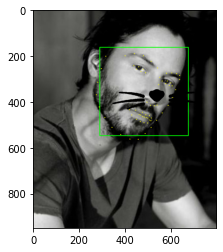

In [16]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

sticker_path = os.getenv('HOME')+'/aiffel/fundamental/0930/images/catwhisker.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
plt.imshow(img_sticker)
print (img_sticker.shape)

# 스티커 불러오기/리사이즈

refined_x = x - w // 2  # left
refined_y = y       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))


sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

* 어두워서 잘 안보이는 경향이 있긴하지만 수염이 사진에 잘 맞지 않는다. 

##### 랜드마크의 회전각을 구하고 스티커에 적용해보기

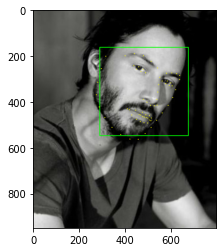

In [17]:
my_image_path = os.getenv('HOME')+'/aiffel/fundamental/0930/images/keanu_tilted.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

model_path = os.getenv('HOME')+'/aiffel/fundamental/0930/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [18]:
x = []
y = []
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x.append(landmark[30][0])    # x = landmark[30][0]
    y.append(landmark[30][1] - dlib_rect.width()//2)  # y =land~~
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ("얼굴 폭 높이",'(w,h) : (%d,%d)'%(w,h))

얼굴 폭 높이 (w,h) : (386,386)


In [19]:
# 회전 각 구하기
import math

tan_theta = (landmark[30][0]-landmark[27][0])/(landmark[30][1]-landmark[27][1])
theta = np.arctan(tan_theta)
rotate_angle = theta *180/math.pi
print(rotate_angle)

-7.711892412658882


(386, 386, 3)


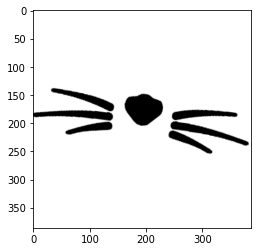

In [20]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR,borderValue=(255,255,255))
  return result

img_rotate = rotate_image(img_sticker,rotate_angle)
print(img_rotate.shape)
plt.imshow(img_rotate)
plt.show()

In [21]:
refined_x = []
refined_y = []
for i in range(len(x)):
    refined_x.append(x[i] - w//2)  # left
    refined_y.append(y[i])     # top

In [22]:
for i in range(len(x)):
    sticker_area = img_bgr[refined_y[i]:refined_y[i]+img_rotate.shape[0], refined_x[i]:refined_x[i]+img_rotate.shape[1]]
    img_show[refined_y[i]:refined_y[i]+img_rotate.shape[0], refined_x[i]:refined_x[i]+img_rotate.shape[1]] = np.where(img_rotate==255,sticker_area,img_rotate).astype(np.uint8)

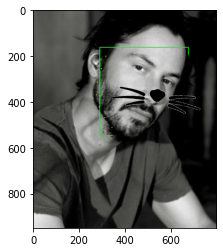

In [23]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

* 회전각을 적용하니 아까 보다는 더 잘 맞는 듯하다.

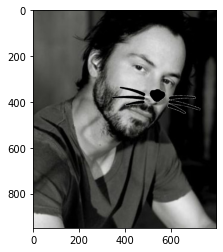

In [24]:
for i in range(len(x)):
    sticker_area = img_bgr[refined_y[i]:refined_y[i]+img_sticker.shape[0], refined_x[i]:refined_x[i]+img_sticker.shape[1]]
    img_bgr[refined_y[i]:refined_y[i]+img_sticker.shape[0], refined_x[i]:refined_x[i]+img_sticker.shape[1]] = np.where(img_rotate==255,sticker_area,img_rotate).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

#### 3.2 거리

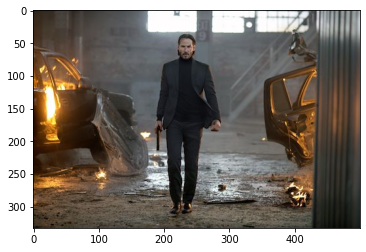

In [25]:
my_image_path = os.getenv('HOME')+'/aiffel/fundamental/0930/images/keanu_full.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [26]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
dlib_rects = detector_hog(img_rgb, 1)   # detector_hog(image, 이미지 피라미드 수)
print(dlib_rects)   # 찾은 얼굴영역 좌표

rectangles[]


* 얼굴 영역 좌표를 찾을 수 없다. 작아도 detect할 수 있는 모델이 있는지 모르겠다. 

#### 3.3 실행속도와 정확성

* 랜드마크를 파악하고 스티커의 위치를 찾는 것이 빠르고 정확히 이루어지려면, 사진에 있는 스티커를 적용할 인물이나 대상의 각도, 거리, 여러 명의 유무까지 고려했을 때 어떤 방식으로 진행하는 것이 효과적일까...? 스티커의 적용은 랜드마크가 잘 파악이 되면, 그것에 따라 바꾸고 적용하는 건 쉬울 것 같다. 대상이 멀리 있거나, 각도가 다르거나, 여러 인물들이 있더라도 얼굴과 랜드마크가 인식이 되는 것이 성능의 포인트가 될 것 같다. 육안으로도 멀리 있거나 여러 명이 있으면 한번에 얼굴 feature를 파악하는 것이 힘든데, 랜드마크 모델이 랜드마크를 인식하는 방법이 사람이 물체를 파악하는 방법과 어떻게 다른지 궁금하기도 하다. 